#**Step 01: Installing the Packages**

In [ ]:
# %%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade
!pip install super-gradients
!pip install ultralytics
!pip install opencv-python

#**Step 02: Importing all the required libraries**

In [5]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


from IPython.display import clear_output

from super_gradients.training import models



#**Step 03: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [ ]:
#ROHIT NEW DATASET
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NUxUOBclariZXlPocJE0")
project = rf.workspace("rohit-sjsqg").project("rohit-isl")
version = project.version(17)
dataset = version.download("yolov8")



#**Step 04: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [6]:
CHECKPOINT_DIR = '/content/ROHIT-ISL-17'
trainer = Trainer(experiment_name='/content/drive/MyDrive/Training_100', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 05: Load your dataset parameters into a dictionary**

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [7]:
dataset_params = {
    'data_dir':'/content/ROHIT-ISL-17',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['1', '3', '4', '5', '6', '8', 'A', 'Age', 'B', 'C', 'Cow', 'D', 'Dog', 'E', 'Elephant', 'F', 'Fish', 'Frog', 'G', 'H', 'Home', 'I', 'Internet', 'J', 'K', 'L', 'Laptop', 'M', 'Mobile', 'Monkey', 'N', 'Namastey', 'O', 'Owl', 'P', 'Photo', 'Q', 'R', 'S', 'School', 'Signature', 'Sleep', 'Snake', 'Spider', 'Stand', 'Sun', 'T', 'Technology', 'U', 'V', 'W', 'X', 'Y', 'Yellow', 'Z', 'accept', 'antelope', 'assistant', 'bag', 'black', 'book', 'boot', 'bottle', 'bull', 'camel', 'card', 'cash', 'cat', 'chicken', 'colour', 'crocodile', 'dupatta', 'earpods', 'fast', 'goat', 'gun', 'hair', 'handkerchief', 'help', 'heron', 'horse', 'human', 'idea', 'jeans', 'keep', 'location', 'meet', 'peacock', 'pen', 'person', 'proof', 'rain', 'saree', 'shoot', 'star', 'tiger', 'tv', 'umbrella', 'white', 'wolf']
}





#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':32,
        'num_workers':4
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':32,
        'num_workers':4
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':32,
        'num_workers':4
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 273/273 [00:00<00:00, 2369.53it/s]


#**Step 07: Inspect the Dataset Defined Earlier**

In [10]:
train_data.dataset.transforms

In [11]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [12]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 25.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

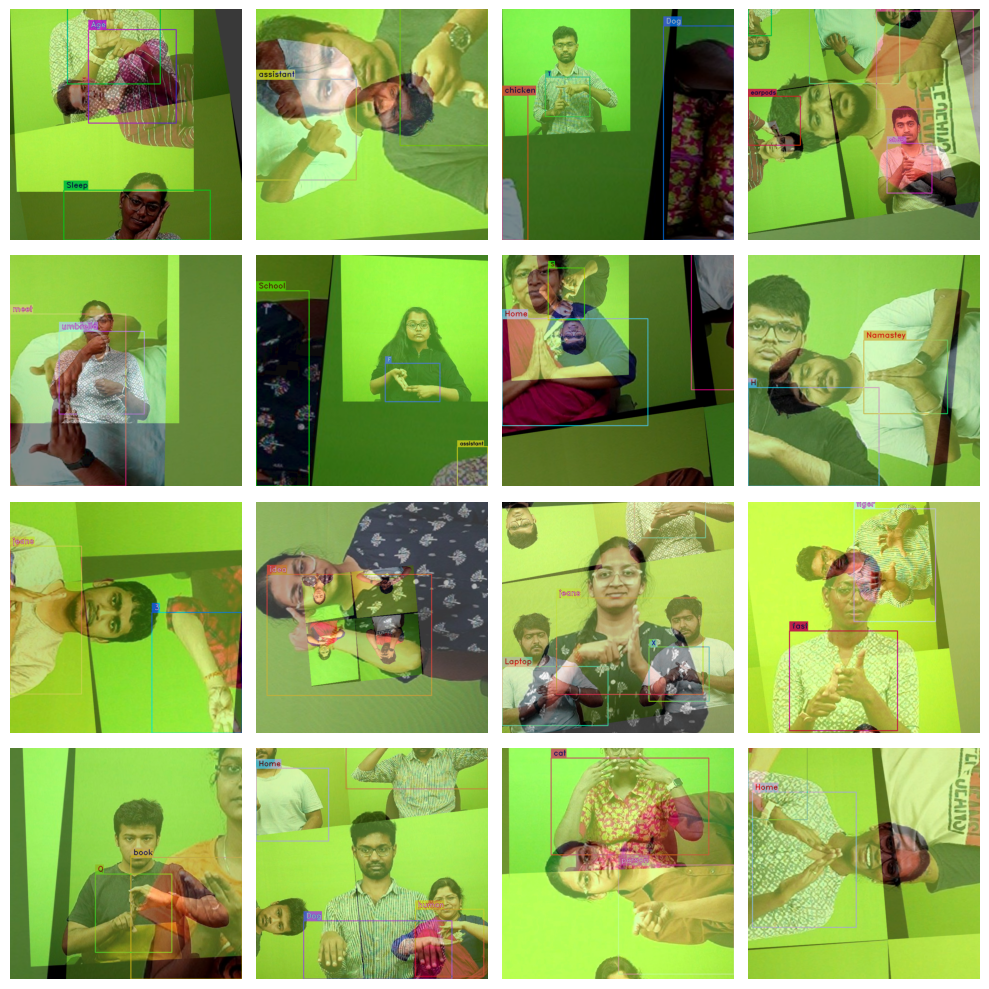

In [14]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**


You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [15]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-08-27 07:19:03] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-08-27 07:19:03] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:03<00:00, 23.9MB/s]
[2024-08-27 07:19:07] INFO - checkpo

#**Step 10: 📊 Define metrics and training parameters**


We need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).



- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


In [16]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},

    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=200
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.2,
            top_k_predictions=600,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.02,
                nms_top_k=1000,
                max_predictions=600,
                nms_threshold=0.8
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 12: Training the model**

You've covered a lot of ground so far:

 1.Instantiated the trainer

2. Defined your dataset parameters and dataloaders

3. Instantiated a model

4. Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

#**Step 13:Get the best trained model**

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/drive/MyDrive/Google_colab_model/RUN_20240731_115326_360524/ckpt_best.pth")

#**Step 14:  Evaluating the best trained model on the test set**

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.2,
                                                   top_k_predictions=600,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.02,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=600,
                                                                                                          nms_threshold=0.8)
                                                  ))

#**Step 15:  Predicting with the best model**



In [ ]:
import cv2
from PIL import Image
import numpy as np

img_path = '/content/ROHIT-ISL-17/valid/images/agrima115_jpg.rf.f003e4c05fc070c7e2e7fa9186401a30.jpg'

# Load image using OpenCV
img_cv = cv2.imread(img_path)
if img_cv is None:
    print("Failed to load image with OpenCV.")
else:
    # Convert the image to RGB (OpenCV loads images in BGR format by default)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Convert the image to a PIL Image
    img_pil = Image.fromarray(img_rgb)
    # Now pass the PIL Image to your model for prediction
    best_model.predict(img_pil).show()


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Directory containing the images
folder_path = '/content/ROHIT-ISL-17/valid/images'

# Load image using OpenCV
img_cv = cv2.imread(img_path)
if img_cv is None:
    print("Failed to load image with OpenCV.")
else:
    # Convert the image to RGB (OpenCV loads images in BGR format by default)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Convert the image to a PIL Image
    img_pil = Image.fromarray(img_rgb)
    # Now pass the PIL Image to your model for prediction
    best_model.predict(img_pil).show()


# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you might want to add more robust checks)
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Construct the full path to the image file
        img_path = os.path.join(folder_path, filename)

        # Load image using OpenCV
        img_cv = cv2.imread(img_path)

        if img_cv is None:
            print(f"Failed to load image {filename} with OpenCV.")
        else:
            # Convert the image to RGB (OpenCV loads images in BGR format by default)
            img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            # Convert the image to a PIL Image
            img_pil = Image.fromarray(img_rgb)
            # Now pass the PIL Image to your model for prediction
            best_model.predict(img_pil).show()




**Precision Valu & mAP@50 **

#  #step 16 : Real Time Live Testing  

In [ ]:
import cv2
from super_gradients.training import models

model = models.get('yolo_nas_s', num_classes=100, checkpoint_path='D:\\ROHIT\\FINAL_TESTED\\Final_Model\\100_classes\\RUN_20240730_032315_960354\\100ckpt_best.pth')

model.eval()
output = model.predict_webcam()
print(output)# You may need to handle or process the output depending on your use case.

# Convert the model to ONNX format
models.convert_to_onnx(model=model, input_shape=(3, 640, 640), out_path='custom.onnx')


# Step 17:  Testing on Video

In [ ]:

input_video_path = f"/content/demo5.mp4"
output_video_path = "detections2.mp4"


import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

best_model.to(device).predict(input_video_path).save(output_video_path)
